<a href="https://colab.research.google.com/github/oliverlibaw/oliverlibaw/blob/main/Your_First_Deep_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your First Deep Learning Model

This is a step-by-step guide of how to train a deep learning model using Convolutional Neural Networks to recognize handwritten digits.

First, let's install Comet.ml and initialize it. The first time you run this cell, you'll need to paste the API Key from your Comet.ml account.

Comet.ml will monitor training, logging metrics, parameters, and histograms to your code without requiring you to do anything other than adding these lines of code, and setting the experiment parameters to the appropriate values for what you would like to log:

In [ ]:
!pip install comet-ml

import comet_ml
from comet_ml import Experiment

comet_ml.init()

experiment = Experiment(
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


COMET INFO: Comet API key is valid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/svpino/general/711f557810b5464db85e0da989e4308f
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1eY1oBKaknSTwdCesLLozwXepFGO_gTUn
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fa

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# Loading and transforming the data

Loading the MNIST dataset is very simple using Keras. You can use access it through `datasets.mnist` and use the `load_data()` function to get a train and a test set.

The dataset contains 28x28 images of handwritten digits.

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

If you print the shape the any of the sets you will see more information about the samples.

For example, printing the shape of the train set will get you `(60000, 28, 28)`:

* `60000`: This is the number of samples in the set.
* `28`: This is the height of each image.
* `28`: This is the width of each image.

So we have 60,000 28x28 images.

In [ ]:
print(X_train.shape)

(60000, 28, 28)


Anytime you are using a neural network, you should pay special attention to the range of the input values you will be feeding it. In our case, each image is a matrix of 28x28 pixels. 

Let's print the range of these values to understand what's the scale we are working with:

In [ ]:
X_train[0].min(), X_train[0].max()

(0, 255)

The pixel values in our images are between 0 (black) to 255 (white). 

Neural networks have a much easier time working with values that don't vary a lot in scale. It's a common practice to scale every input to fit a small range like 0 to 1 or -1 to 1.

We should do that here, and scale our pixels to a range that goes from 0 (black) to 1 (white). 

Here is the formula to scale a value: `scaled_value = (original_value – min) / (max – min)`. In our case, the minimum value is 0 and the maximum value is 255.

Let's use this to scale our train and test sets (notice that you can get rid of the `0.0` in the formula below but I'm leaving them there for clarity purposes):

In [ ]:
X_train = (X_train - 0.0) / (255.0 - 0.0)
X_test = (X_test - 0.0) / (255.0 - 0.0)

X_train[0].min(), X_train[0].max()

(0.0, 1.0)

We can now plot the first 20 images on the train set:

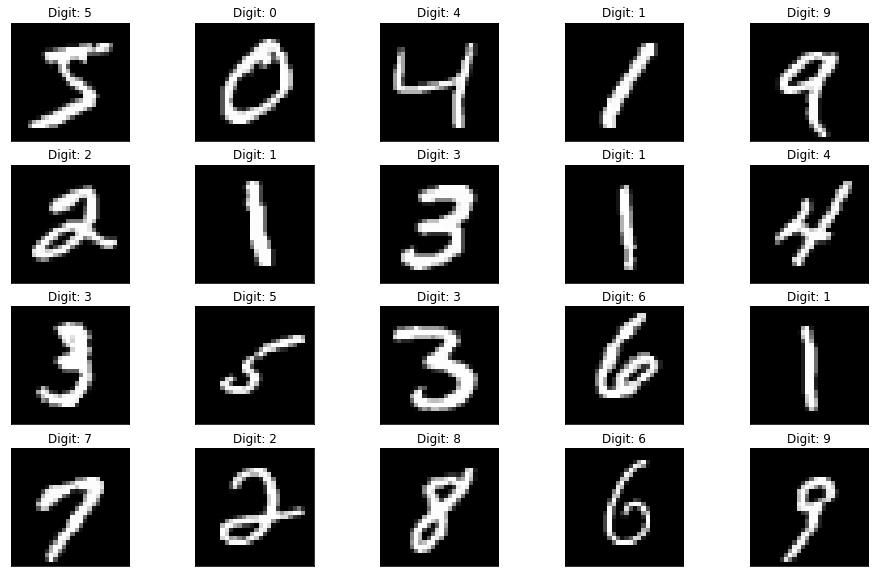

In [ ]:
def plot_digit(image, digit, plt, i):
    plt.subplot(4, 5, i + 1)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.title(f"Digit: {digit}")
    plt.xticks([])
    plt.yticks([])


plt.figure(figsize=(16, 10))
for i in range(20):
    plot_digit(X_train[i], y_train[i], plt, i)
    
plt.show()

We use 4 dimensions to represent a set of images:

1. The total number of images (we call this "*batch size*")
2. The width of each image
3. The height of each image
4. The number of channels of each image

As you saw before, our train set has 3 dimensions only; we are missing the number of channels. We need to transform our data by adding that fourth dimension. Since these images are grayscale, that fourth dimension will be 1.

We can use numpy's `reshape()` function to reshape all of the data by adding that extra dimension.

In [ ]:
X_train = X_train.reshape((X_train.shape + (1,)))
X_test = X_test.reshape((X_test.shape + (1,)))

Finally, let's take a look at the format of our target values (`y_train`). Let's print the first 20 samples in our train set:

In [ ]:
y_train[0:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

We are representing the target digits using integers (the digit 5 is represented with value 5, the digit 0 with value 0, etc.) This is important because it determines which loss function we should use to optimize our neural network.

We have two options:

1. Use integers for our target values (as they are now), and make sure we use the "Sparse Categorical Cross-Entropy" loss function.
2. One-hot encode the targets and use the "Categorical Cross-Entropy" loss function.

The easiest solution is to leave the targets as they are, so let's move on to creating the model.

# Building the model

There are several ways to create a model in Keras. In this example, we are going to use Keras' Sequential API because it's very simple to use.

Let's break down the definition of the model below step by step:

1. First, we are going to define the first hidden layer of our network: A convolutional layer with 32 filters and a 3x3 kernel. This layer will use a ReLU activation function. The goal of this layer is to generate 32 different representations of an image, each one of 26x26. The 3x3 kernel will discard a pixel on each side of the original image and that's way we get 26x26 feature maps instead of 28x28.

2. Notice how we also need to define the input shape of the network as part of that first layer. Remember that our images are 28x28 with a single color channel, so that leads to the `(28, 28, 1)` shape.

3. Right after that first layer, we are going to do a 2x2 max pooling to downsample the amount of information generated by the convolutional layer. This operation will half the size of the filters. Remember we start with 32 filters of 26x26, so after this operation will have 32 filters of 13x13.

4. We then take the `(13, 13, 32)` vector and flatten it to a (5408,) vector. Notice that 13 x 13 x 32 = 5408.

5. Finally, we add a couple more fully-connected layers (also called `Dense` layers.) Notice how the output layer has size 10 (one for each of our possible digit values) and a `softmax` activation. Softmax ensures we get a probability distribution indicating the most likely digit in the image.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])

We now have our model. The next step is to define how we want to train it:

1. Let's use an `SGD` optimizer (Stochastic Gradient Descent) with `0.01` as the learning rate.
2. As we discussed before, we need to use the `sparse_categorical_crossentropy` loss because our target values are represented as integers.
3. And we are going to compute `accuracy` of our model as we train it.

Notice in the summary of the model the shape of the vectors as they move through the layers we defined. They should look familiar after reading the explanation of our model above.

In [ ]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    optimizer=optimizer, 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               540900    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

# Training and testing the model

At this point we are ready to fit our model on the train set.

For this example, we are going to run batches of 32 samples through our model for 10 iterations (epochs.) This should be enough to get a model with good predictive capabilities.

*Note: This network is fairly shallow so it shouldn't take a long time to train it on a CPU. If you have access to a GPU it should be much faster.*

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2362 - accuracy: 0.9279
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0772 - accuracy: 0.9768
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0502 - accuracy: 0.9848
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0363 - accuracy: 0.9890
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0275 - accuracy: 0.9919
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0210 - accuracy: 0.9933
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0143 - accuracy: 0.9955
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0102 - accuracy: 0.9974
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0083 - accuracy: 0.9979
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.005

At this point you should have a model that scored above 99% accuracy on the train set. 

Now it's time to test it with a few of the images that we set aside on our test set. Let's run 20 random images through t\he model and display them together with the predicted digit:

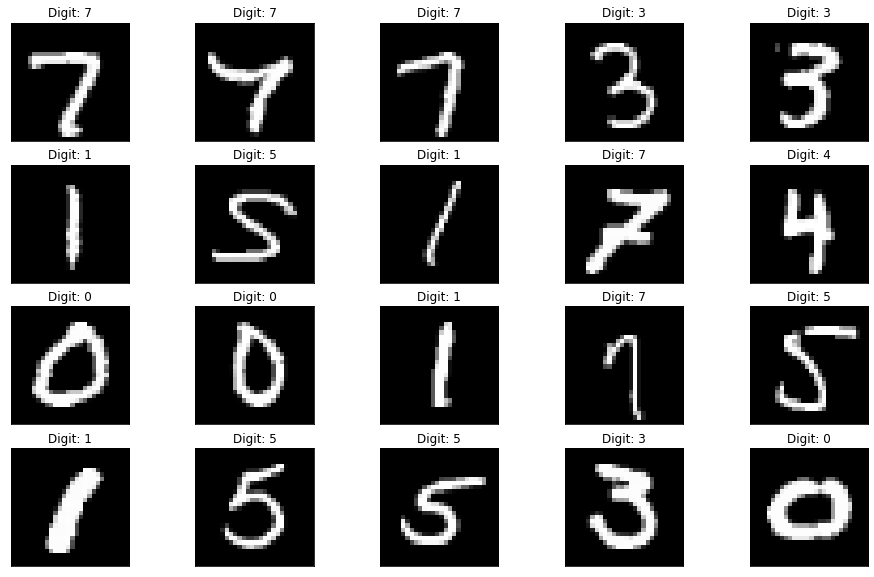

In [ ]:
plt.figure(figsize=(16, 10))
for i in range(20):
    image = random.choice(X_test).squeeze()
    digit = np.argmax(model.predict(image.reshape((1, 28, 28, 1)))[0], axis=-1)
    plot_digit(image, digit, plt, i)

plt.show()

The results look pretty good! 

To get a much better idea about the quality of the predictions, we can run the entire test set (10,000 images) through the model and compute the final accuracy. To do this we can use the `accuracy_score()` function from SciKit-Learn passing a couple of arguments:

* True values: The correct digit expected for each image. These are the values we have stored in `y_test`.
* Predicted values: The predictions that our model made. These are the results of our model.

The final accuracy will be the value printed after running the cell.

In [ ]:
predictions = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, predictions)
experiment.log_confusion_matrix(y_test, predictions)

{'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=20ee157ce5ca411ab514b5b156758650&experimentKey=baff2e45db5b4988a66c9b34c903efc1',
 'assetId': '20ee157ce5ca411ab514b5b156758650',
 'web': 'https://www.comet.com/api/asset/download?assetId=20ee157ce5ca411ab514b5b156758650&experimentKey=baff2e45db5b4988a66c9b34c903efc1'}